In [90]:
import tensorflow as tf
from tensorflow import keras
import os
from glob import glob
import matplotlib.pyplot as plt
import albumentations as A

## Preprocessing

In [91]:
from imgaug import augmenters as iaa
from PIL import Image
import numpy as np
from imageio import imwrite

img_height = 256
img_width = 256

A_transforms = A.Compose([
    A.Resize(height=img_height, width=img_width),
])

iaa_transforms = iaa.Sequential([iaa.SaltAndPepper(0.2)])

<class 'numpy.ndarray'>


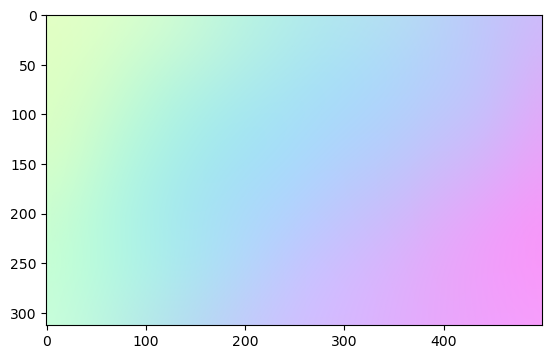

In [92]:
working_dir = "./images_parent/"
images_list = glob(working_dir + "images/*")

test_image = plt.imread(images_list[2])
print(type(test_image))
plt.imshow(test_image)

In [93]:
def apply_transforms(isAdditionalApplied=False):
    for image_name in images_list:
        base_name = os.path.basename(image_name) ## ADDITIONAL: Will the Filename matter? JPEG uses YUV coloring, PNG uses RGB...
        image = Image.open(image_name).convert("RGB")
        image = np.array(image)
        print(image.shape)

        image = A_transforms(image=image)
        image = image['image'] ## Albumentations likes to cast the array to 'dict', accessed by key 'image'
        image = image.astype(np.uint8)

        if(isAdditionalApplied): ## apply additional transforms to image to create "mod" folder
            image = iaa_transforms.augment_image(image=image) ## apply salt-pepper
            mod_save_path = r"./images_parent/images_mod/mod"
            imwrite(mod_save_path + base_name, image)

        else: ## apply transforms to normal image 
            normal_save_path = r"./images_parent/images/"
            imwrite(normal_save_path + base_name, image)

    print()

apply_transforms(False)
apply_transforms(True)

(720, 830, 3)
(256, 256, 3)
(313, 500, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)



length of noised images 8
length of normal images 8
Length of noised numpy array 8
Length of normal numpy array 8


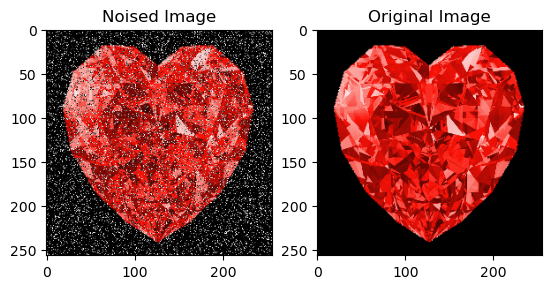

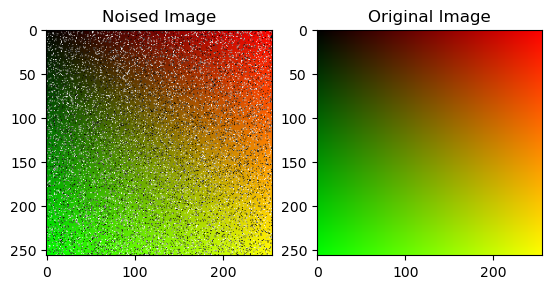

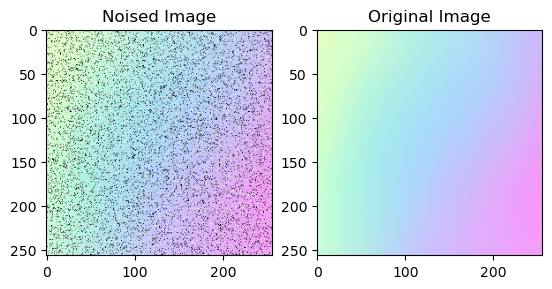

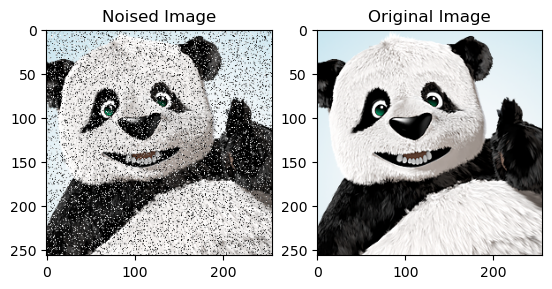

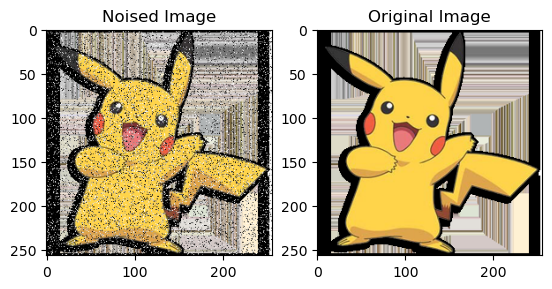

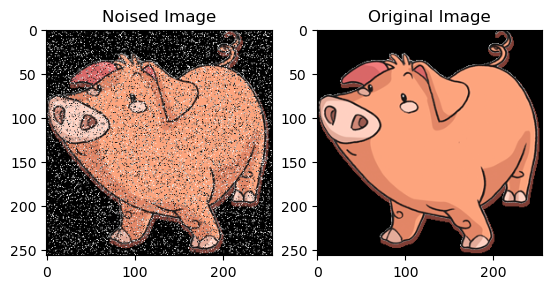

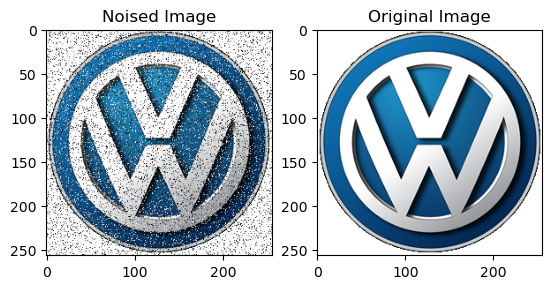

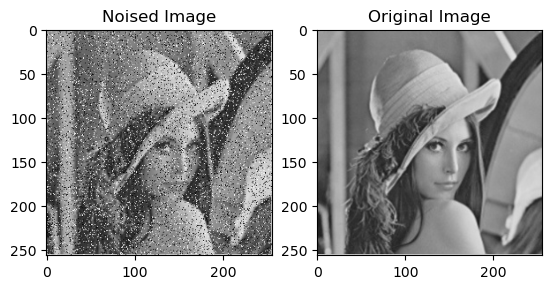

<Figure size 640x480 with 0 Axes>

In [95]:
noised_images = glob("./images_parent/images_mod/*")
normal_images = glob("./images_parent/images/*")

print(f"length of noised images {len(noised_images)}")
print(f"length of normal images {len(normal_images)}")

noised_images_input = []
normal_images_target = []

for i in range(min(len(noised_images), len(normal_images))):
    noised_image = plt.imread(noised_images[i]).astype(np.float32) ## numpy array
    normal_image = plt.imread(normal_images[i]).astype(np.float32) ## numpy array
    
    ## NOTE: .astype(np.float32) works only for PNGS!(Must be using RGB24 coloring!). JPG/JPEGS don't work
    
    ## Saving images as numpy to list
    noised_images_input.append(noised_image)
    normal_images_target.append(normal_image)
    
    plt.subplot(1, 2, 1)
    plt.title("Noised Image")
    plt.imshow(noised_image)

    plt.subplot(1, 2, 2)
    plt.title("Original Image")
    plt.imshow(normal_image)
    
    plt.figure()
    
print(f"Length of noised numpy array {len(noised_images_input)}")
print(f"Length of normal numpy array {len(normal_images_target)}")

#print(type(noised_images_input[0][0][0][0])) ## UINT8 image saved as...

## Build Keras Dataset

In [96]:
BATCH_SIZE = 8

In [97]:
noise_ds = tf.data.Dataset.from_tensor_slices((noised_images_input, normal_images_target)).batch(BATCH_SIZE)
#print(next(iter(noise_ds))

(8, 256, 256, 3)
(8, 256, 256, 3)
(256, 256, 3)
(256, 256, 3)
tf.Tensor(
[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.23529412 0.23529412 0.23529412]
   [0.         0.         0.        ]]

  [[0.70980394 0.70980394 0.70980394]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.89411765 0.89411765 0.89411765]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.13725491 0.13725491 0.13725491]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.      

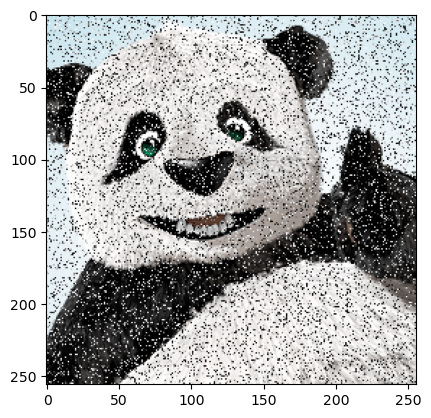

In [98]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

test_image_batch, test_label_batch = noise_ds.get_single_element()


print(test_image_batch.shape)
print(test_label_batch.shape)

print(test_image_batch[3].shape)
print(test_label_batch[3].shape)

print(test_image_batch)

plt.imshow(test_image_batch[3])


## Build Model

In [130]:
from tensorflow.keras.models import Model
from tensorflow.keras import losses
from tensorflow.keras.layers import Rescaling, Input, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose

In [131]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      Input(shape=(256, 256, 3)),
      Conv2D(64, (3, 3), activation='relu', padding='same'),
      MaxPool2D((2, 2), padding='same'),
      Conv2D(32, (3, 3), activation='relu', padding='same'),
      MaxPool2D((2, 2), padding='same'),
      Conv2D(16, (3, 3), activation='relu', padding='same'),
      MaxPool2D((2, 2), padding='same')
    ], name="Encoder")

    self.decoder = tf.keras.Sequential([
      Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2D(3, kernel_size=(3, 3), padding='same')
    ], name="Decoder")


  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [155]:
class Denoise2(Model):
  def __init__(self):
    super(Denoise2, self).__init__()
    self.encoder = tf.keras.Sequential([
      Input(shape=(256, 256, 3)),
      Conv2D(32, (3, 3), strides=2, activation='relu', padding='same'),
      Conv2D(16, (3, 3), strides=2, activation='relu', padding='same'),
    ], name="Encoder")

    self.decoder = tf.keras.Sequential([
      Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
    ], name="Decoder")


  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise2()

In [156]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredLogarithmicError())


In [170]:
%xmode Verbose
print(type(noise_ds))

EPOCHS = 500 ## ~1:40.0 run for 500 epochs
autoencoder.fit(noise_ds, epochs=EPOCHS) ## WHEN WRITING CUSTOM DATASETS, ALWAYS SPECIFY BATCHSIZE BEFOREHANDS

Exception reporting mode: Verbose
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Epoch 1/500
1/1 [==============================] - 1s 561ms/step - loss: 0.0043
Epoch 2/500
1/1 [==============================] - 0s 406ms/step - loss: 0.0043
Epoch 3/500
1/1 [==============================] - 0s 247ms/step - loss: 0.0043
Epoch 4/500
1/1 [==============================] - 0s 218ms/step - loss: 0.0043
Epoch 5/500
1/1 [==============================] - 0s 218ms/step - loss: 0.0043
Epoch 6/500
1/1 [==============================] - 0s 216ms/step - loss: 0.0043
Epoch 7/500
1/1 [==============================] - 0s 155ms/step - loss: 0.0043
Epoch 8/500
1/1 [==============================] - 0s 148ms/step - loss: 0.0043
Epoch 9/500
1/1 [==============================] - 0s 158ms/step - loss: 0.0043
Epoch 10/500
1/1 [==============================] - 0s 167ms/step - loss: 0.0044
Epoch 11/500
1/1 [==============================] - 0s 161ms/step - loss: 0.0044
Epoch 12/500
1/1 [====

In [171]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()


Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_43 (Conv2D)          (None, 64, 64, 16)        4624      
                                                                 
Total params: 5,520
Trainable params: 5,520
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_30 (Conv2D  (None, 128, 128, 16)     2320      
 Transpose)                                                      
                                                                 
 conv2d_transpose_31 (Conv2D  (None, 256, 256, 32)     4640      
 Transpose)                             

## Some Testing

Image Batch shape: (8, 256, 256, 3)
Label Batch shape: (8, 256, 256, 3)
1/1 [==============================] - 0s 78ms/step


<Figure size 640x480 with 0 Axes>

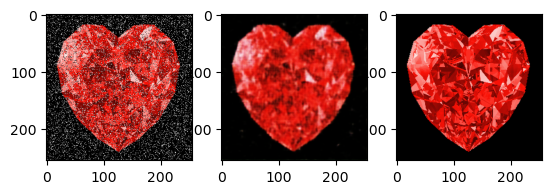

<Figure size 640x480 with 0 Axes>

In [180]:
test_image_batch, test_label_batch = noise_ds.get_single_element()

print(f"Image Batch shape: {test_image_batch.shape}")
print(f"Label Batch shape: {test_label_batch.shape}")


predicted_output = autoencoder.predict(test_image_batch)

test_num = 0

original_noised_image = test_image_batch[test_num]
predicted_image = predicted_output[test_num]
label_image = test_label_batch[test_num]

plt.subplot(131)
plt.imshow(original_noised_image)
plt.subplot(132)
plt.imshow(predicted_image)
plt.subplot(133)
plt.imshow(label_image)
plt.figure()